In [3]:
! . .venv/bin/activate
! sstat -j $SLURM_JOB_ID 

JobID         MaxVMSize  MaxVMSizeNode  MaxVMSizeTask  AveVMSize     MaxRSS MaxRSSNode MaxRSSTask     AveRSS MaxPages MaxPagesNode   MaxPagesTask   AvePages     MinCPU MinCPUNode MinCPUTask     AveCPU   NTasks AveCPUFreq ReqCPUFreqMin ReqCPUFreqMax ReqCPUFreqGov ConsumedEnergy  MaxDiskRead MaxDiskReadNode MaxDiskReadTask  AveDiskRead MaxDiskWrite MaxDiskWriteNode MaxDiskWriteTask AveDiskWrite TRESUsageInAve TRESUsageInMax TRESUsageInMaxNode TRESUsageInMaxTask TRESUsageInMin TRESUsageInMinNode TRESUsageInMinTask TRESUsageInTot TRESUsageOutAve TRESUsageOutMax TRESUsageOutMaxNode TRESUsageOutMaxTask TRESUsageOutMin TRESUsageOutMinNode TRESUsageOutMinTask TRESUsageOutTot 
------------ ---------- -------------- -------------- ---------- ---------- ---------- ---------- ---------- -------- ------------ -------------- ---------- ---------- ---------- ---------- ---------- -------- ---------- ------------- ------------- ------------- -------------- ------------ --------------- --------------- 

# Trian Test Split (70 - 15 - 15)

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error, mean_squared_error, r2_score, confusion_matrix
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
# Load the dataset
file_path = 'balanced_ml_dataset.csv'
data = pd.read_csv(file_path)

# Assuming the target variable is named 'target'
# Replace 'target' with the actual column name of your target variable
X = data.drop(columns=['causedPressure'])  # Features
y = data['causedPressure']  # Target variable

# Step 1: Split into train and temp (70-30 split)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Step 2: Split temp into validation and test (50-50 split of the remaining 30%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Print the sizes of each dataset
print("Training set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])
print("Test set size:", X_test.shape[0])


Training set size: 4575
Validation set size: 980
Test set size: 981


In [6]:
# Print the percentage of positive examples in the y_train, y_val, and y_test
print("Percentage of positive examples in y_train:", y_train.mean())
print("Percentage of positive examples in y_val:", y_val.mean())
print("Percentage of positive examples in y_test:", y_test.mean())

Percentage of positive examples in y_train: 0.5001092896174864
Percentage of positive examples in y_val: 0.5
Percentage of positive examples in y_test: 0.49949031600407745


# Baseline Model

In [ ]:
# Initialize and train the Linear Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on validation and test sets
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Evaluate the model on the validation set
print("Validation Metrics:")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_val, y_val_pred):.4f}")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_val, y_val_pred):.4f}")
print(f"R² Score: {r2_score(y_val, y_val_pred):.4f}")

# Evaluate the model on the test set
print("\nTest Metrics:")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_test_pred):.4f}")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, y_test_pred):.4f}")
print(f"R² Score: {r2_score(y_test, y_test_pred):.4f}")

# Optional: Compare actual vs predicted values on the test set
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})
print("\nSample Predictions:")
print(results.head())

# Calculate accuracy
accuracy = accuracy_score(y_test, y_test_pred.round())
print(f"Test Accuracy: {accuracy:.4f}")

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_test_pred.round())

# Print the raw confusion matrix
print("Confusion Matrix:")
print(cm)

# Optional: Visualize the confusion matrix with a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# XGBoost model

In [5]:
# 5. Create and train the XGBoost model
#    - We use early stopping on the validation set to avoid overfitting.
model = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',  # As of xgboost > 1.3, you should specify eval_metric
    early_stopping_rounds=10

)

model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    verbose=True
)

# 6. Evaluate the model on the test set
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# 7. Print a classification report for detailed metrics
print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred))

[0]	validation_0-logloss:0.67365
[1]	validation_0-logloss:0.66557
[2]	validation_0-logloss:0.66575
[3]	validation_0-logloss:0.66565
[4]	validation_0-logloss:0.66656
[5]	validation_0-logloss:0.66863
[6]	validation_0-logloss:0.67031
[7]	validation_0-logloss:0.67147
[8]	validation_0-logloss:0.67343
[9]	validation_0-logloss:0.67526
[10]	validation_0-logloss:0.67726
[11]	validation_0-logloss:0.67914
Test Accuracy: 0.6218
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.62      0.63      0.62       491
           1       0.62      0.62      0.62       490

    accuracy                           0.62       981
   macro avg       0.62      0.62      0.62       981
weighted avg       0.62      0.62      0.62       981



/blue/hoover-sai/NFL_Big_Data_Bowl_2025/team1/aaron_dir/big-data-bowl/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:22:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Confusion Matrix:
[[307 184]
 [187 303]]


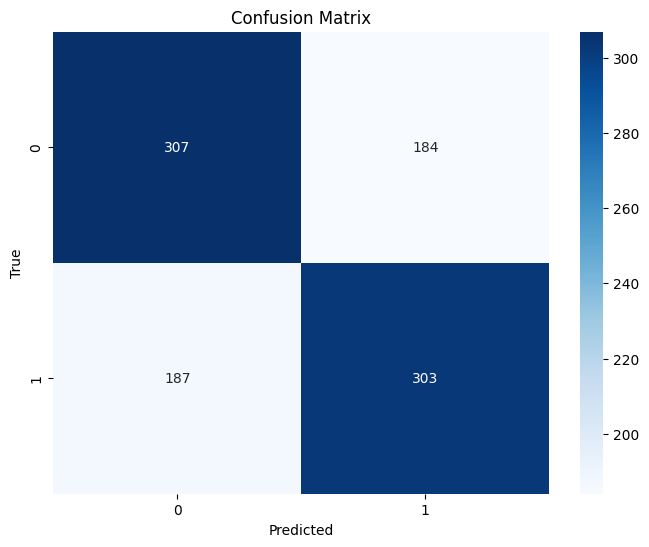

In [6]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print the raw confusion matrix
print("Confusion Matrix:")
print(cm)

# Optional: Visualize the confusion matrix with a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Hyperparamater Tuning

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/blue/hoover-sai/NFL_Big_Data_Bowl_2025/team1/aaron_dir/big-data-bowl/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:26:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/blue/hoover-sai/NFL_Big_Data_Bowl_2025/team1/aaron_dir/big-data-bowl/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:26:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/blue/hoover-sai/NFL_Big_Data_Bowl_2025/team1/aaron_dir/big-data-bowl/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:26:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/blue/hoover-sai/NFL_Big_Data_Bowl_2025/team1/aaron_dir/big-data-bowl/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:26:27] WARNING: /workspace

Best parameters found:  {'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 0.01, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.3, 'colsample_bytree': 0.8}
Best CV accuracy:  0.6330054644808744
Validation Accuracy with tuned model: 0.6061
Test Accuracy with tuned model: 0.6340
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.64      0.63      0.63       491
           1       0.63      0.64      0.64       490

    accuracy                           0.63       981
   macro avg       0.63      0.63      0.63       981
weighted avg       0.63      0.63      0.63       981

Confusion Matrix:
[[309 182]
 [177 313]]


/blue/hoover-sai/NFL_Big_Data_Bowl_2025/team1/aaron_dir/big-data-bowl/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:26:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


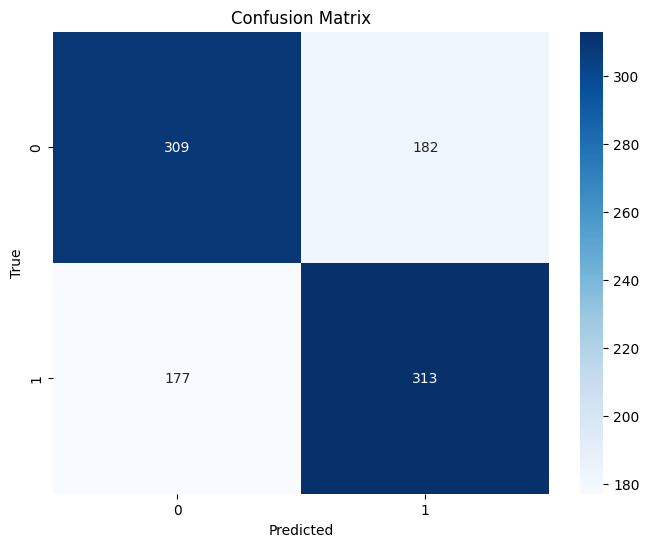

In [11]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
import numpy as np

# 1. Define a parameter grid for XGBoost hyperparameters
param_dist = {
    "n_estimators": [50, 100, 200, 300],
    "max_depth": [3, 4, 5, 6],
    "learning_rate": [0.1, 0.01, 0.001],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "min_child_weight": [1, 3, 5],
    "gamma": [0, 0.1, 0.3, 0.5],
    "reg_alpha": [0, 0.01, 0.1, 1],
    "reg_lambda": [0, 0.01, 0.1, 1]
}

# 2. Initialize an XGBoost classifier
xgb_clf = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# 3. Instantiate the RandomizedSearchCV
#    n_iter: number of random parameter settings to try
#    cv: number of folds in cross-validation
#    scoring: metric used for selection
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=20,                  # Adjust to your preference
    scoring='accuracy',         # Could be 'f1', 'roc_auc', etc. depending on the problem
    cv=3,                       # K-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1                   # Use all available cores
)

# 4. Fit the RandomizedSearchCV on your training set
random_search.fit(X_train, y_train)

# 5. Check best parameters and score
print("Best parameters found: ", random_search.best_params_)
print("Best CV accuracy: ", random_search.best_score_)

# 6. Use the best_estimator_ to predict on validation/test set
best_model = random_search.best_estimator_

# If you have a separate validation set
y_val_pred = best_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy with tuned model: {val_accuracy:.4f}")

# 7. Evaluate on test set
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy with tuned model: {test_accuracy:.4f}")

print("Classification Report on Test Set:")
print(classification_report(y_test, y_test_pred))

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Print the raw confusion matrix
print("Confusion Matrix:")
print(cm)

# Optional: Visualize the confusion matrix with a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
